In [48]:
import json
import os
import pickle
from sklearn.neighbors import NearestNeighbors


import numpy as np

benders_data_path = "experiment-output/ch7/3nodes/benders_data"
training_data_path = "experiment-output/ch7/ED_NB-G-F_GB2-G2-F2_L3_c0_s0_p0_smp15.pkl"

# Training data
training_data = pickle.load(open(training_data_path, "rb"))
args = json.load(open("config.json", "r"))
indices = np.arange(training_data.X.shape[0])
train_size = int(args["train"] * training_data.X.shape[0])
valid_size = int(args["valid"] * training_data.X.shape[0])
train_indices = indices[:train_size]
valid_indices = indices[train_size:train_size+valid_size]
test_indices = indices[train_size+valid_size:]

X_training = training_data.X[train_indices]
X_test = training_data.X[test_indices]
Y_training = training_data.opt_targets["y_operational"][train_indices]
Y_test = training_data.opt_targets["y_operational"][test_indices]
opt_mu_training = training_data.opt_targets["mu_operational"][train_indices]
opt_lamb_training = training_data.opt_targets["lamb_operational"][train_indices]
opt_mu_test = training_data.opt_targets["mu_operational"][test_indices]
opt_lamb_test = training_data.opt_targets["lamb_operational"][test_indices]

# Benders data
X_benders = pickle.load(open(os.path.join(benders_data_path, "X.pkl"), "rb"))
objs_benders = pickle.load(open(os.path.join(benders_data_path, "objs.pkl"), "rb"))
dual_solutions_benders = pickle.load(open(os.path.join(benders_data_path, "dual_solutions.pkl"), "rb"))
primal_solutions_benders = pickle.load(open(os.path.join(benders_data_path, "primal_solutions.pkl"), "rb"))



In [49]:
print(f"X_training.shape: {X_training.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"X_benders.shape: {X_benders.shape}")



X_training.shape: torch.Size([26214, 9])
X_test.shape: torch.Size([3278, 9])
X_benders.shape: torch.Size([4920, 9])


In [50]:
# kNN
nn = NearestNeighbors(n_neighbors=100).fit(X_training)
distances_test, _ = nn.kneighbors(X_test)
distances_benders, _ = nn.kneighbors(X_benders)

print(f"distances_test.mean(): {distances_test.mean()}")
print(f"np.median(distances_test): {np.median(distances_test)}")
print(f"distances_test.max(): {distances_test.max()}")

print(f"distances_benders.mean(): {distances_benders.mean()}")
print(f"np.median(distances_benders): {np.median(distances_benders)}")
print(f"distances_benders.max(): {distances_benders.max()}")

distances_test.mean(): 45041.94509336752
np.median(distances_test): 45618.42095083257
distances_test.max(): 90976.15219637356
distances_benders.mean(): 49907.09139020204
np.median(distances_benders): 51035.19416859659
distances_benders.max(): 90438.51741288803


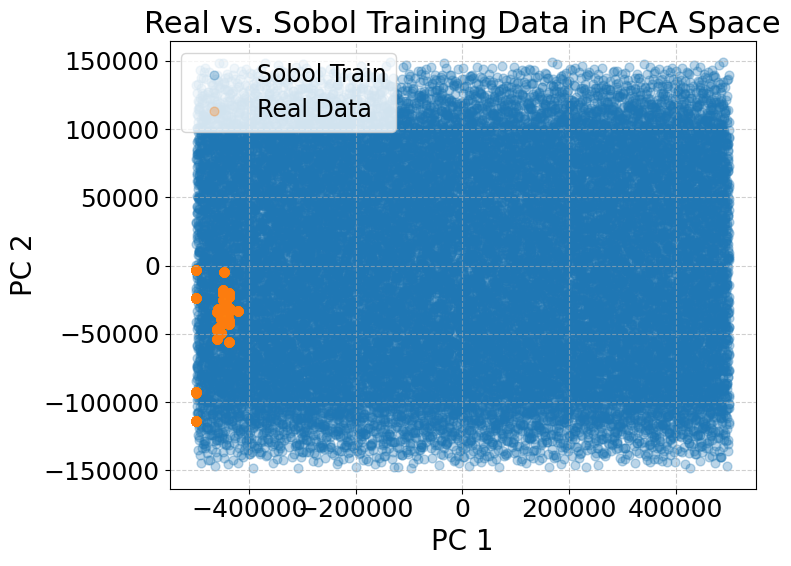

In [51]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Fit PCA on the training (Sobol) data
pca = PCA(n_components=2)
pca.fit(X_training)

# Project both datasets using the same PCA basis
train_2d = pca.transform(X_training)
real_2d = pca.transform(X_benders)

plt.rcParams.update({
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 17,
    "font.size": 18
})

tab10 = plt.get_cmap("tab10")
train_color = tab10(0)  # blue
real_color = tab10(1)   # orange

plt.figure(figsize=(8, 6))
plt.scatter(train_2d[:, 0], train_2d[:, 1], alpha=0.3, label='Sobol Train', color=train_color, s=40, rasterized=True)
plt.scatter(real_2d[:, 0], real_2d[:, 1], alpha=0.3, label='Real Data', color=real_color, s=40, rasterized=True)
plt.legend(loc='best', frameon=True)
plt.title('Real vs. Sobol Training Data in PCA Space')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("figures/ch8-pca_real_vs_sobol.pdf", dpi=300, bbox_inches='tight')
plt.show()

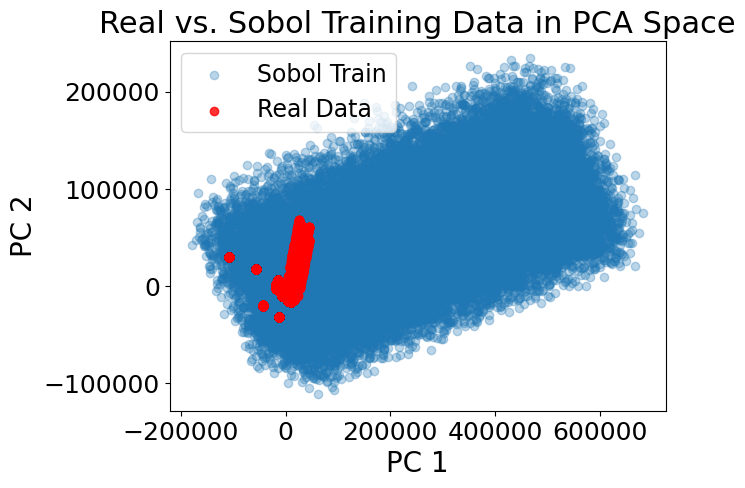

In [52]:
# Fit PCA on the training (Sobol) data
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca.fit(X_benders)

# Project both datasets using the same PCA basis
train_2d = pca.transform(X_training)
real_2d = pca.transform(X_benders)

# Plot both
plt.scatter(train_2d[:, 0], train_2d[:, 1], alpha=0.3, label='Sobol Train')
plt.scatter(real_2d[:, 0], real_2d[:, 1], alpha=0.8, label='Real Data', c='red')
plt.legend()
plt.title('Real vs. Sobol Training Data in PCA Space')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

In [53]:
import torch
from networks import DualClassificationNetEndToEnd, PrimalNetEndToEnd, PrimalNetEndToEnd2


path = "experiment-output/ch7/3nodes/dual_model"
with open(os.path.join(path, 'args.json'), 'r') as f:
        dual_args = json.load(f)
dual_net = DualClassificationNetEndToEnd(dual_args, data=training_data)
dual_net.load_state_dict(torch.load(os.path.join(path, 'dual_weights.pth'), weights_only=True))
dual_net.eval()

primal_path = "experiment-output/ch7/3nodes/primal_model"
with open(os.path.join(primal_path, 'args.json'), 'r') as f:
        primal_args = json.load(f)
#! Optuna args
best_args = {'primal_lr': 0.0006785456069117277, 'hidden_size_factor': 28, 'n_layers': 2, 'decay': 0.9989743016070536, 'batch_size': 2048}  #! Temporary, for primal net
primal_args["primal_lr"] = best_args["primal_lr"]
primal_args["hidden_size_factor"] = best_args["hidden_size_factor"]
primal_args["n_layers"] = best_args["n_layers"]
primal_args["decay"] = best_args["decay"]
primal_args["batch_size"] = best_args["batch_size"]
primal_net = PrimalNetEndToEnd2(primal_args, training_data)
primal_net.load_state_dict(torch.load(os.path.join(primal_path, "primal_weights.pth"), weights_only=True))
primal_net.eval()


pWeight = 120/8760 #! sample_duration = 120

mu_benders, lamb_benders = dual_net(X_benders)
Y_benders = primal_net(X_benders)

mu_benders/=pWeight
lamb_benders/=pWeight

mu_training, lamb_training = dual_net(X_training)
mu_test, lamb_test = dual_net(X_test)
Y_pred_training = primal_net(X_training)
Y_pred_test = primal_net(X_test)

dual_obj_benders = training_data.dual_obj_fn(X_benders, mu_benders, lamb_benders)
dual_opt_gap_benders = (dual_obj_benders - objs_benders) / objs_benders

dual_obj_training = training_data.dual_obj_fn(X_training, mu_training, lamb_training)
known_obj_training = training_data.dual_obj_fn(X_training, opt_mu_training, opt_lamb_training)
dual_opt_gap_training = (dual_obj_training - known_obj_training) / known_obj_training

dual_obj_test = training_data.dual_obj_fn(X_test, mu_test, lamb_test)
known_obj_test = training_data.dual_obj_fn(X_test, opt_mu_test, opt_lamb_test)
dual_opt_gap_test = (dual_obj_test - known_obj_test) / known_obj_test

primal_obj_benders = training_data.obj_fn(X_benders, Y_benders).detach().cpu().numpy() / pWeight
primal_opt_gap_benders = (primal_obj_benders - objs_benders) / objs_benders

primal_obj_training = training_data.obj_fn(X_training, Y_pred_training)
primal_opt_gap_training = ((primal_obj_training - known_obj_training) / known_obj_training).detach().cpu().numpy()

primal_obj_test = training_data.obj_fn(X_test, Y_pred_test)
primal_opt_gap_test = ((primal_obj_test - known_obj_test) / known_obj_test).detach().cpu().numpy()





print("Dual")
print(dual_opt_gap_benders.mean(), dual_opt_gap_benders.min(), dual_opt_gap_benders.max())
print(dual_opt_gap_training.mean(), dual_opt_gap_training.min(), dual_opt_gap_training.max())
print(dual_opt_gap_test.mean(), dual_opt_gap_test.min(), dual_opt_gap_test.max())

print("Primal")
print(primal_opt_gap_benders.mean(), primal_opt_gap_benders.min(), primal_opt_gap_benders.max())
print(primal_opt_gap_training.mean(), primal_opt_gap_training.min(), primal_opt_gap_training.max())
print(primal_opt_gap_test.mean(), primal_opt_gap_test.min(), primal_opt_gap_test.max())


Dual
tensor(-0.2872) tensor(-17.2146) tensor(3.4972e-16)
tensor(-0.0345) tensor(-96.2141) tensor(0.)
tensor(-0.0380) tensor(-26.8699) tensor(0.)
Primal
5.881595494987231 -5.809001034629497e-16 42.793011810137195
0.0020165538691994814 -1.0128286747284184e-15 8.458395277349554
0.007693726074487586 -2.1402925887882058e-16 10.004973194283183


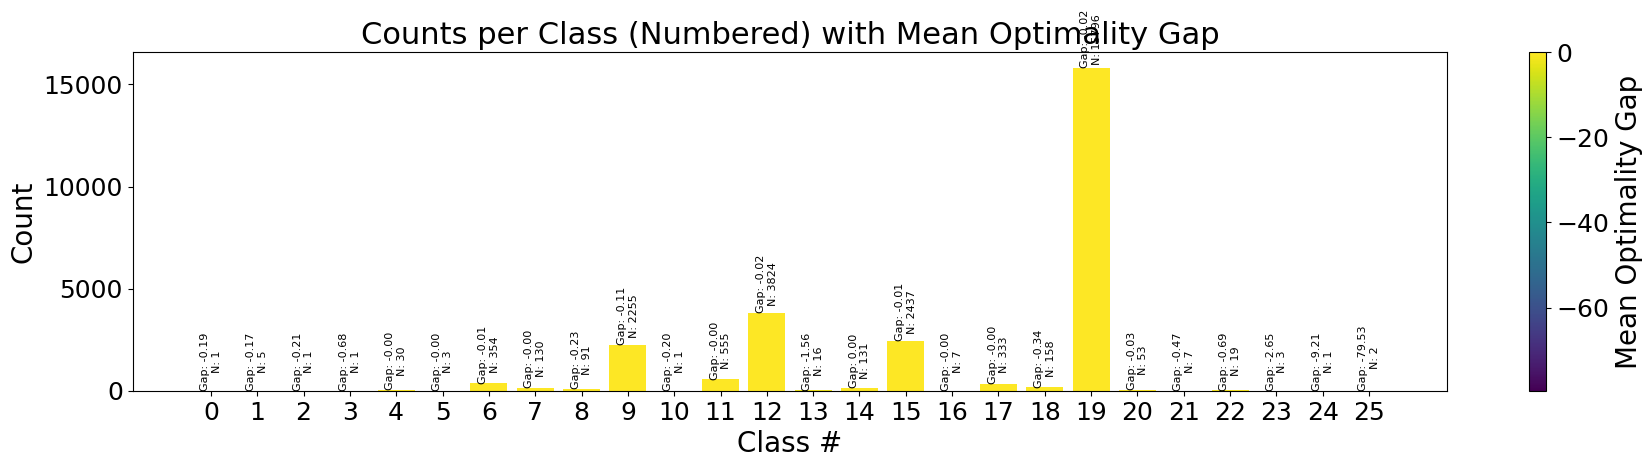

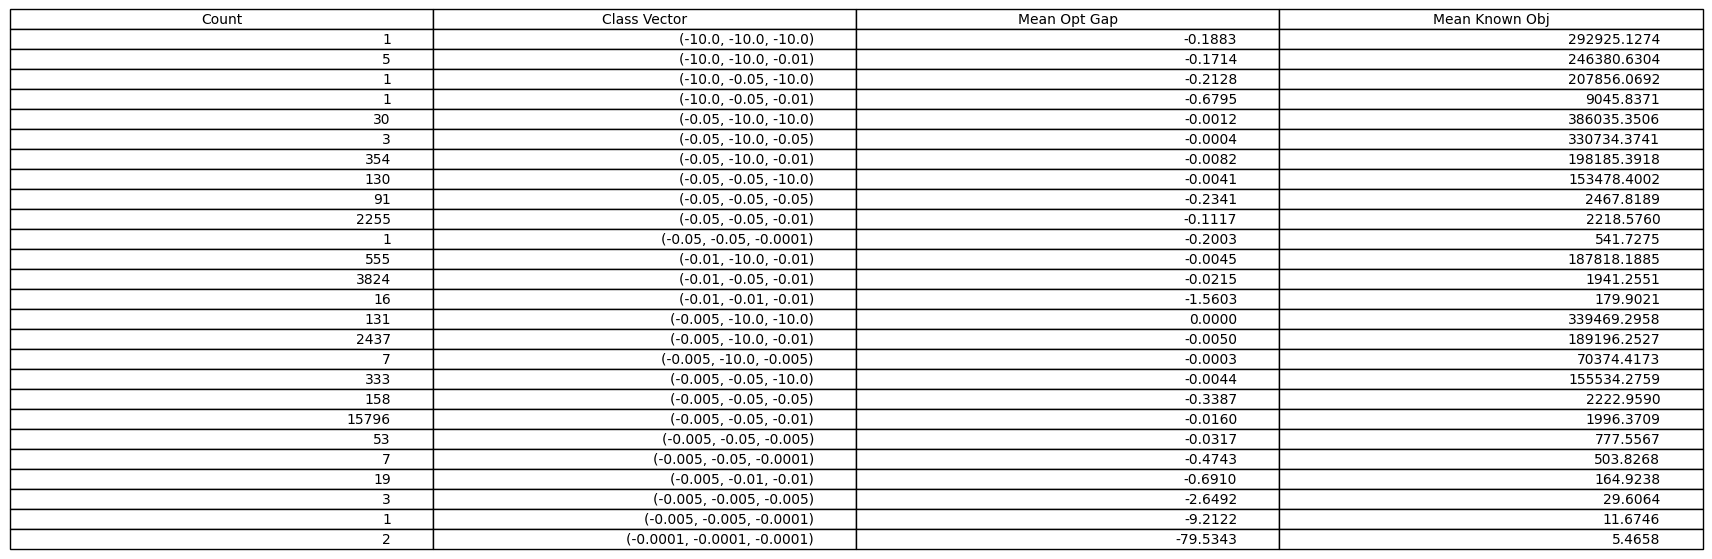

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Get unique classes and convert everything to numpy
classes = opt_lamb_training.unique(dim=0).detach().cpu().numpy()
target_lamb_np = opt_lamb_training.detach().cpu().numpy()
dual_opt_gap_np = dual_opt_gap_training.detach().cpu().numpy()
known_obj_np = known_obj_training.detach().cpu().numpy()

# Prepare storage
class_numbers = list(range(len(classes)))
opt_gap_classes = []
counts = []
known_obj_means = []
class_vectors = []

# Loop over classes and collect stats
for num, c in enumerate(classes):
    matches = np.all(target_lamb_np == c, axis=1)
    indices = np.where(matches)[0]
    count = len(indices)
    counts.append(count)
    class_vectors.append(tuple(float(x) for x in c))  # keep floats, not rounded
    if count > 0:
        mean_gap = dual_opt_gap_np[indices].mean()
        mean_known_obj = known_obj_np[indices].mean()
    else:
        mean_gap = np.nan
        mean_known_obj = np.nan
    opt_gap_classes.append(mean_gap)
    known_obj_means.append(mean_known_obj)

# Plot histogram with numbered classes
fig, ax = plt.subplots(figsize=(max(10, len(classes)*0.7), 5))
bars = ax.bar(
    class_numbers,
    counts,
    color=plt.cm.viridis(
        (np.array(opt_gap_classes) - np.nanmin(opt_gap_classes)) / (np.nanmax(opt_gap_classes) - np.nanmin(opt_gap_classes))
    )
)
ax.set_xticks(class_numbers)
ax.set_xticklabels(class_numbers, rotation=0)

sm = plt.cm.ScalarMappable(
    cmap='viridis',
    norm=plt.Normalize(vmin=np.nanmin(opt_gap_classes), vmax=np.nanmax(opt_gap_classes))
)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Mean Optimality Gap')

# Print mean gap and count on each bar
for bar, gap, count in zip(bars, opt_gap_classes, counts):
    ax.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        f"Gap: {gap:.2f}\nN: {count}",
        ha='center', va='bottom', fontsize=8, rotation=90
    )

ax.set_xlabel('Class #')
ax.set_ylabel('Count')
ax.set_title('Counts per Class (Numbered) with Mean Optimality Gap')
plt.tight_layout()
plt.show()

# Build a table for display (with floats, not rounded)
table_data = [
    [
        counts[num],
        str(class_vectors[num]),  # tuple of floats
        f"{opt_gap_classes[num]:.4f}",
        f"{known_obj_means[num]:.4f}"
    ]
    for num in class_numbers
]
colLabels = ["Count", "Class Vector", "Mean Opt Gap", "Mean Known Obj"]

fig2, ax2 = plt.subplots(figsize=(max(10, len(classes)*0.7), 2))
ax2.axis('off')
table = ax2.table(
    cellText=table_data,
    colLabels=colLabels,
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.show()

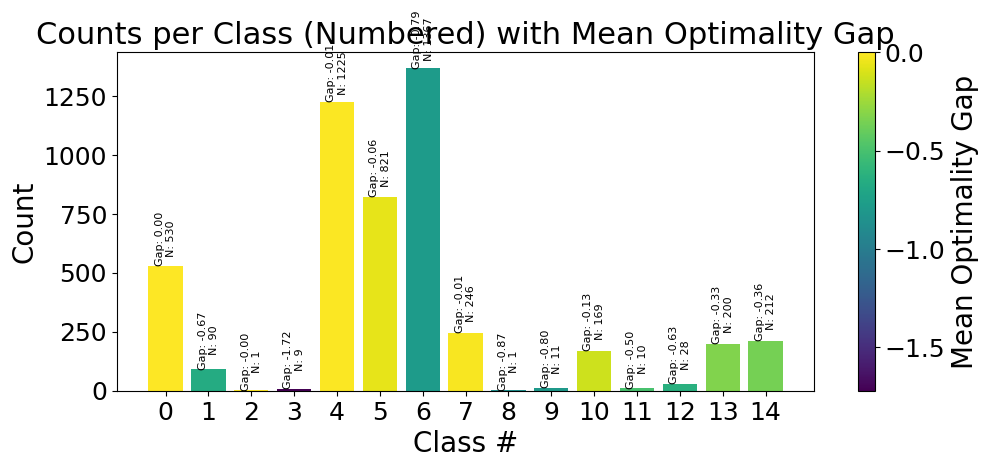

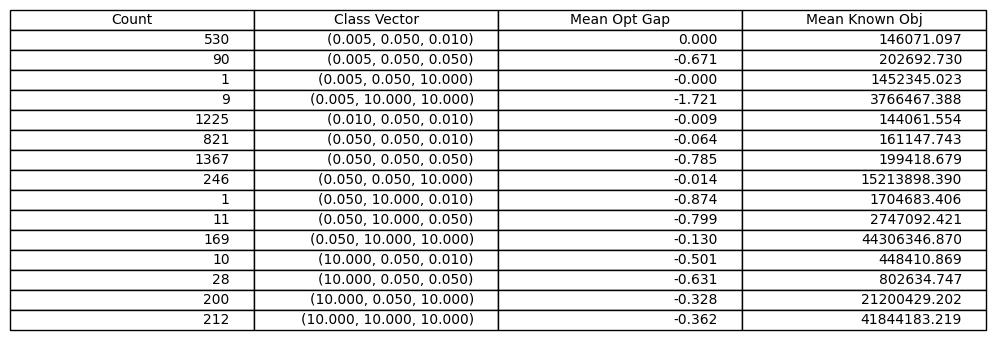

In [55]:
# Get unique classes and convert everything to numpy
pWeight = 120/8760

opt_lamb_benders = dual_solutions_benders[:, -training_data.num_n:] * pWeight
classes = torch.tensor(opt_lamb_benders).unique(dim=0).detach().cpu().numpy()
target_lamb_np = opt_lamb_benders
dual_opt_gap_np = dual_opt_gap_benders.detach().cpu().numpy()
known_obj_np = objs_benders

# Prepare storage
class_numbers = list(range(len(classes)))
opt_gap_classes = []
counts = []
known_obj_means = []
class_vectors = []

# Loop over classes and collect stats
for num, c in enumerate(classes):
    matches = np.all(target_lamb_np == c, axis=1)
    indices = np.where(matches)[0]
    count = len(indices)
    counts.append(count)
    class_vectors.append(tuple(float(x) for x in c))  # keep floats, not rounded
    if count > 0:
        mean_gap = dual_opt_gap_np[indices].mean()
        mean_known_obj = known_obj_np[indices].mean()
    else:
        mean_gap = np.nan
        mean_known_obj = np.nan
    opt_gap_classes.append(mean_gap)
    known_obj_means.append(mean_known_obj)

# Plot histogram with numbered classes
fig, ax = plt.subplots(figsize=(max(10, len(classes)*0.7), 5))
bars = ax.bar(
    class_numbers,
    counts,
    color=plt.cm.viridis(
        (np.array(opt_gap_classes) - np.nanmin(opt_gap_classes)) / (np.nanmax(opt_gap_classes) - np.nanmin(opt_gap_classes))
    )
)
ax.set_xticks(class_numbers)
ax.set_xticklabels(class_numbers, rotation=0)

sm = plt.cm.ScalarMappable(
    cmap='viridis',
    norm=plt.Normalize(vmin=np.nanmin(opt_gap_classes), vmax=np.nanmax(opt_gap_classes))
)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Mean Optimality Gap')

# Print mean gap and count on each bar
for bar, gap, count in zip(bars, opt_gap_classes, counts):
    ax.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        f"Gap: {gap:.2f}\nN: {count}",
        ha='center', va='bottom', fontsize=8, rotation=90
    )

ax.set_xlabel('Class #')
ax.set_ylabel('Count')
ax.set_title('Counts per Class (Numbered) with Mean Optimality Gap')
plt.tight_layout()
plt.show()

# Build a table for display (with floats rounded to 5 decimals)
table_data = [
    [
        counts[num],
        "(" + ", ".join(f"{x:.3f}" for x in class_vectors[num]) + ")",  # tuple of floats, rounded to 3 decimals
        f"{opt_gap_classes[num]:.3f}",
        f"{known_obj_means[num]:.3f}"
    ]
    for num in class_numbers
]
colLabels = ["Count", "Class Vector", "Mean Opt Gap", "Mean Known Obj"]

fig2, ax2 = plt.subplots(figsize=(max(10, len(classes)*0.7), 2))
ax2.axis('off')
table = ax2.table(
    cellText=table_data,
    colLabels=colLabels,
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.show()

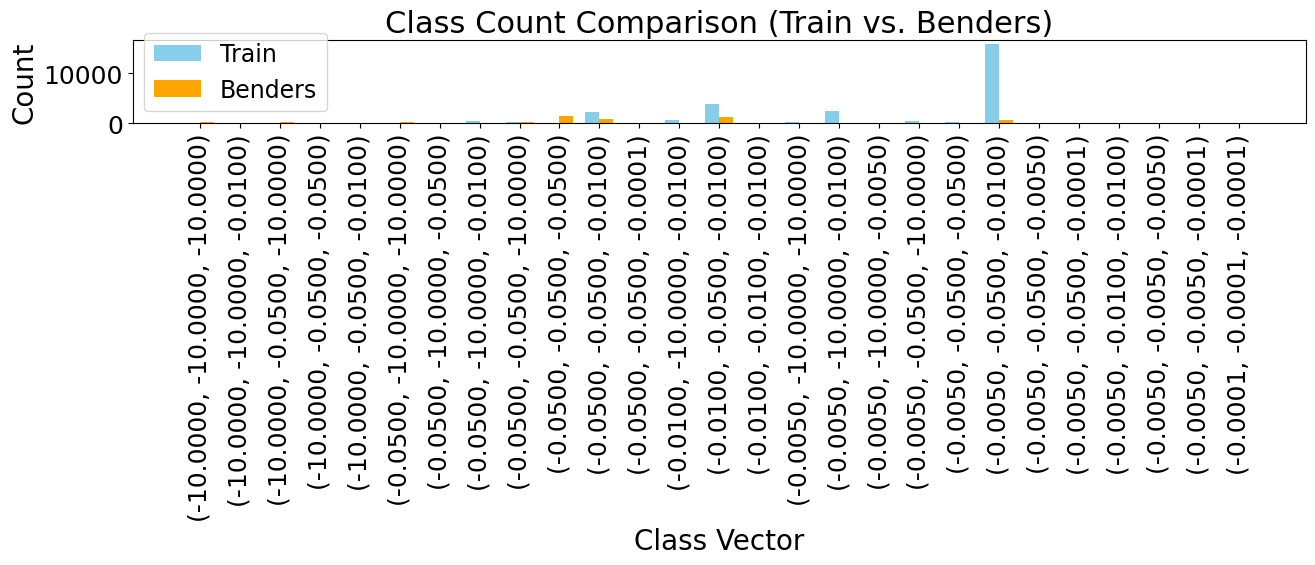

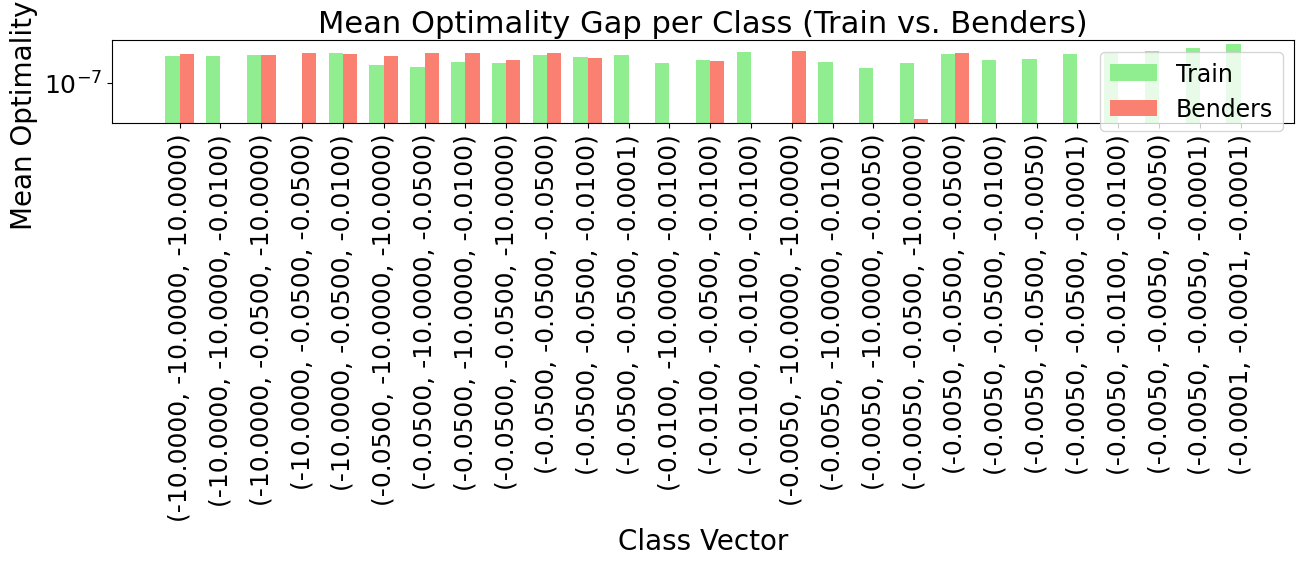

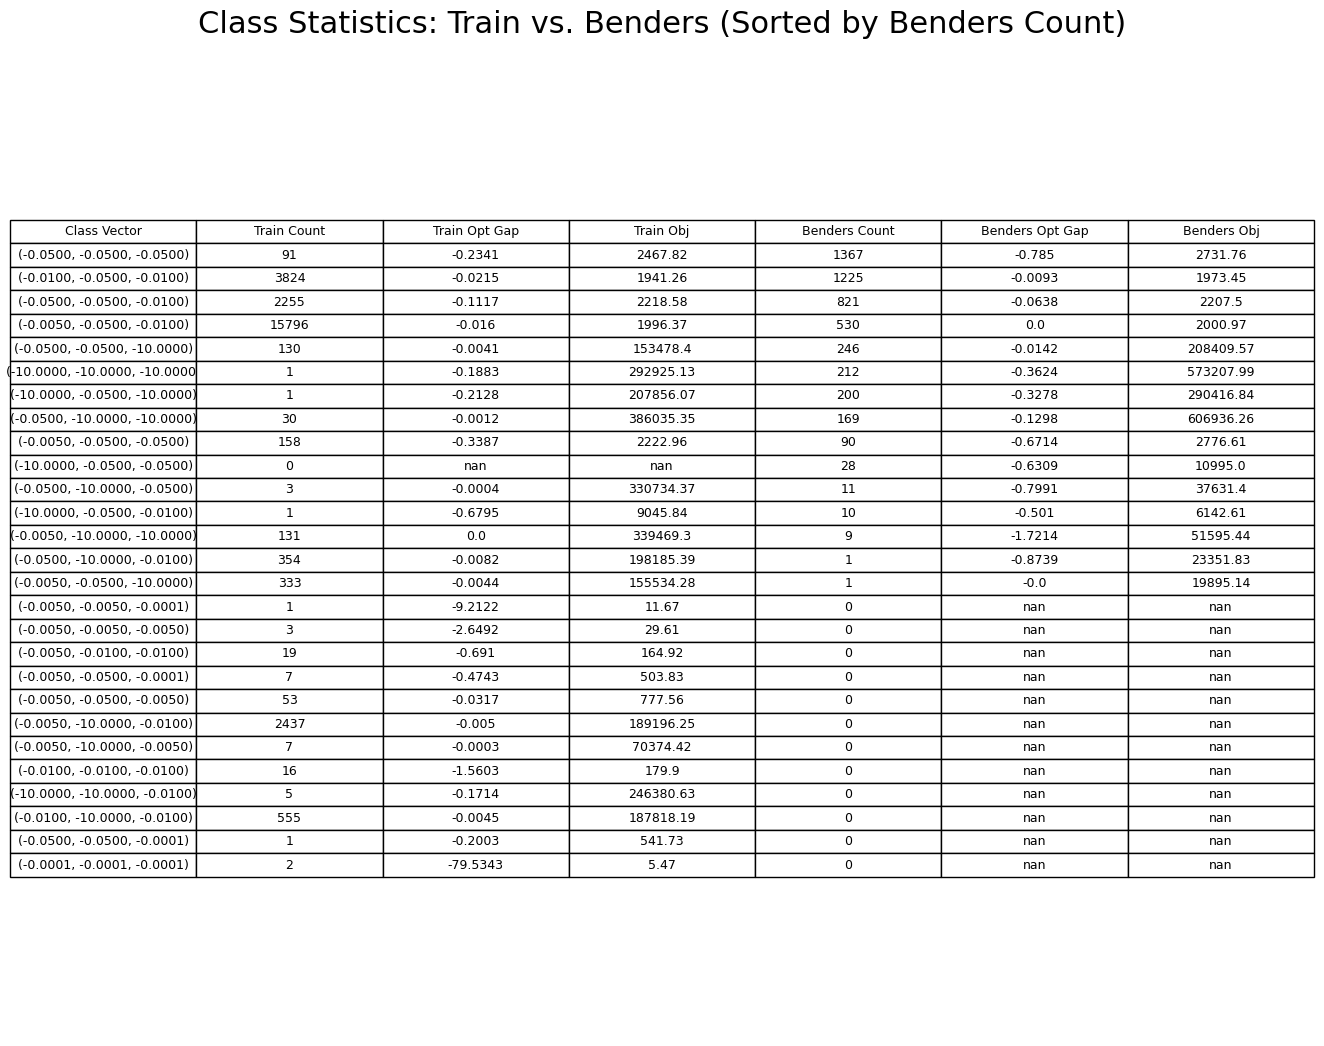

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Convert tensors to numpy ===
classes_train = opt_lamb_training.unique(dim=0).detach().cpu().numpy()
target_lamb_np = opt_lamb_training.detach().cpu().numpy()
dual_opt_gap_np = dual_opt_gap_training.detach().cpu().numpy()
known_obj_np = known_obj_training.detach().cpu().numpy()

pWeight = 120 / 8760
opt_lamb_benders_raw = (dual_solutions_benders[:, -training_data.num_n:] * pWeight)
opt_lamb_benders = np.round(-opt_lamb_benders_raw, decimals=5)  # Negate to match training
classes_benders = np.unique(opt_lamb_benders, axis=0)
dual_opt_gap_np_benders = dual_opt_gap_benders.detach().cpu().numpy()
known_obj_np_benders = objs_benders * pWeight

# === Build class stats dicts ===
def build_class_stats(classes, targets, gaps, objs):
    stats = {}
    for c in classes:
        c_tuple = tuple(c.tolist())
        matches = np.all(np.round(targets, 5) == c, axis=1)
        indices = np.where(matches)[0]
        if len(indices) > 0:
            stats[c_tuple] = {
                "count": len(indices),
                "mean_gap": float(gaps[indices].mean()),
                "mean_obj": float(objs[indices].mean())
            }
    return stats

train_stats = build_class_stats(classes_train, target_lamb_np, dual_opt_gap_np, known_obj_np)
benders_stats = build_class_stats(classes_benders, opt_lamb_benders, dual_opt_gap_np_benders, known_obj_np_benders)

# === Merge both stats ===
all_class_keys = set(train_stats) | set(benders_stats)
merged = []
for key in sorted(all_class_keys):
    row = {
        "Class Vector": key,
        "Count_Train": train_stats.get(key, {}).get("count", 0),
        "Mean Opt Gap_Train": train_stats.get(key, {}).get("mean_gap", np.nan),
        "Mean Known Obj_Train": train_stats.get(key, {}).get("mean_obj", np.nan),
        "Count_Benders": benders_stats.get(key, {}).get("count", 0),
        "Mean Opt Gap_Benders": benders_stats.get(key, {}).get("mean_gap", np.nan),
        "Mean Known Obj_Benders": benders_stats.get(key, {}).get("mean_obj", np.nan),
    }
    merged.append(row)

df = pd.DataFrame(merged)
df = df.sort_values(by="Class Vector")
df["Class Vector (str)"] = df["Class Vector"].apply(lambda x: f"({', '.join(f'{v:.4f}' for v in x)})")


# === Plot 1: Counts ===
x = np.arange(len(df))
width = 0.35

fig, ax = plt.subplots(figsize=(max(10, len(df) * 0.5), 6))
ax.bar(x - width / 2, df["Count_Train"], width, label="Train", color="skyblue")
ax.bar(x + width / 2, df["Count_Benders"], width, label="Benders", color="orange")

ax.set_xticks(x)
ax.set_xticklabels(df["Class Vector (str)"], rotation=90)
ax.set_ylabel("Count")
ax.set_xlabel("Class Vector")
ax.set_title("Class Count Comparison (Train vs. Benders)")
ax.legend()
plt.tight_layout()
plt.show()

# === Plot 2: Mean Optimality Gap ===
fig, ax = plt.subplots(figsize=(max(10, len(df) * 0.5), 6))
ax.bar(x - width / 2, -df["Mean Opt Gap_Train"], width, label="Train", color="lightgreen")
ax.bar(x + width / 2, -df["Mean Opt Gap_Benders"], width, label="Benders", color="salmon")

ax.set_xticks(x)
ax.set_xticklabels(df["Class Vector (str)"], rotation=90)
ax.set_ylabel("Mean Optimality Gap")
ax.set_xlabel("Class Vector")
ax.set_title("Mean Optimality Gap per Class (Train vs. Benders)")
ax.legend()
ax.set_yscale('log')
plt.tight_layout()
plt.show()

# === Plot 3: Entire table ===
# Round values for display
df_display = df[[
    "Class Vector (str)",
    "Count_Train", "Mean Opt Gap_Train", "Mean Known Obj_Train",
    "Count_Benders", "Mean Opt Gap_Benders", "Mean Known Obj_Benders"
]].copy()

# Sort by Benders count (descending)
df_display = df_display.sort_values(by="Count_Benders", ascending=False)

# Round for readability
df_display = df_display.round({
    "Mean Opt Gap_Train": 4,
    "Mean Known Obj_Train": 2,
    "Mean Opt Gap_Benders": 4,
    "Mean Known Obj_Benders": 2
})

# Set column labels
col_labels = [
    "Class Vector", 
    "Train Count", "Train Opt Gap", "Train Obj", 
    "Benders Count", "Benders Opt Gap", "Benders Obj"
]

# Plot the table
fig, ax = plt.subplots(figsize=(max(12, len(df_display) * 0.5), len(df_display) * 0.4))
ax.axis('off')

table = ax.table(
    cellText=df_display.values,
    colLabels=col_labels,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.2)

plt.title("Class Statistics: Train vs. Benders (Sorted by Benders Count)", pad=20)
plt.tight_layout()
plt.show()



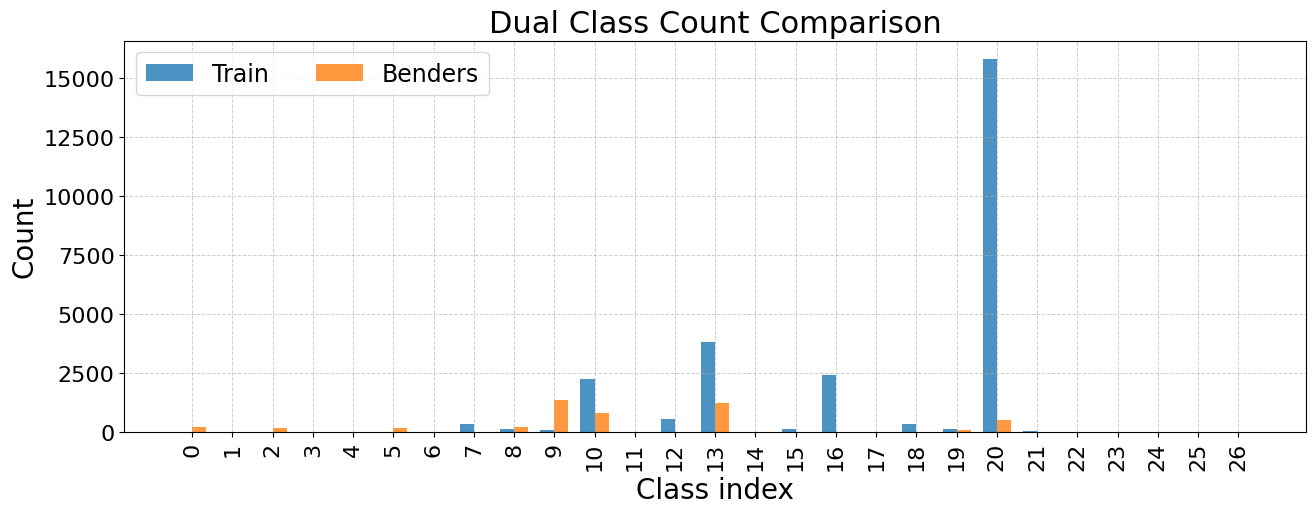

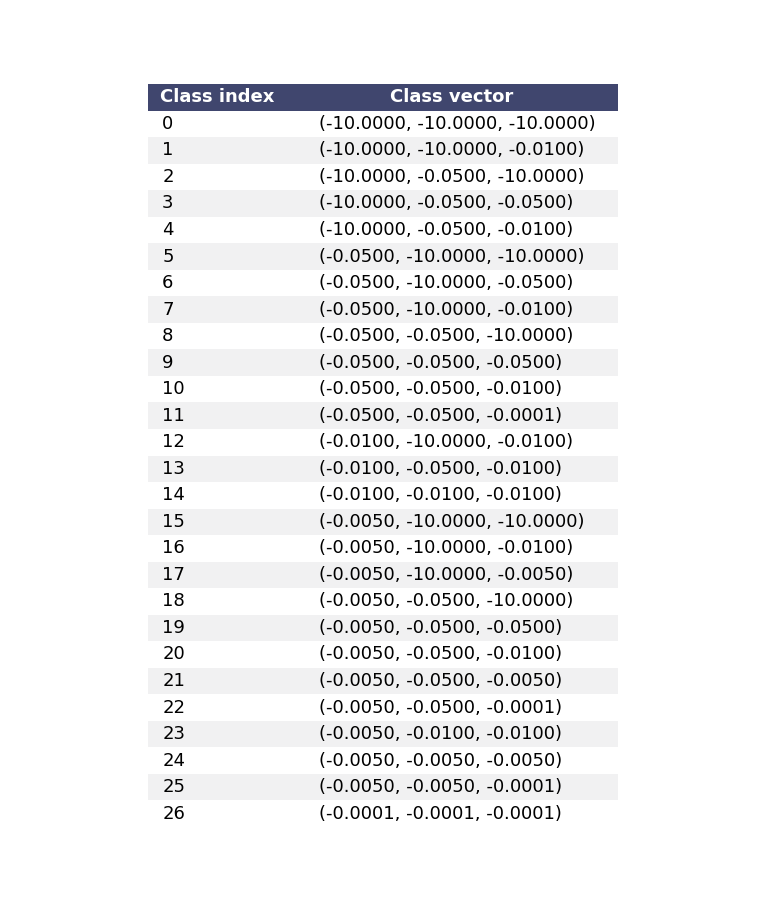

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Assume df is already created as in your code above
x = np.arange(len(df))
width = 0.35

plt.rcParams.update({
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 17,
    "font.size": 18
})

palette = plt.get_cmap("tab10")
train_color = palette(0)
benders_color = palette(1)

fig, ax = plt.subplots(figsize=(max(13, len(df) * 0.5), 6))

bars1 = ax.bar(x - width / 2, df["Count_Train"], width, label="Train", color=train_color, alpha=0.8)
bars2 = ax.bar(x + width / 2, df["Count_Benders"], width, label="Benders", color=benders_color, alpha=0.8)

for bar in bars1 + bars2:
    bar.set_rasterized(True)

ax.set_xticks(x)
ax.set_xticklabels(x, rotation=90, ha='center')
ax.set_ylabel("Count")
ax.set_xlabel("Class index")
plt.yscale('log')
ax.set_title("Dual Class Count Comparison")
ax.legend(loc='upper left', ncol=2, frameon=True)
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7, alpha=0.6)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.subplots_adjust(bottom=0.25)
plt.savefig("figures/ch8-class_count_comparison_thesis.pdf", dpi=300, bbox_inches='tight')
plt.show()

fig, ax_table = plt.subplots(figsize=(max(8, len(df) * 0.25), len(df) * 0.35))
ax_table.axis('off')

# Prepare table data: index and class vector
table_data = [
    [idx, vec] for idx, vec in enumerate(df["Class Vector (str)"])
]
col_labels = ["Class index", "Class vector"]

table = ax_table.table(
    cellText=table_data,
    colLabels=col_labels,
    cellLoc='left',
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(13)
table.scale(1.3, 1.3)

# Format header and alternate row colors
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#40466e')
    else:
        if row % 2 == 0:
            cell.set_facecolor('#f1f1f2')
        else:
            cell.set_facecolor('white')
    cell.set_linewidth(0)

table.auto_set_column_width([0, 1])
plt.tight_layout()
plt.savefig("figures/ch8-class_index_vector_table.pdf", dpi=300, bbox_inches='tight')
plt.show()

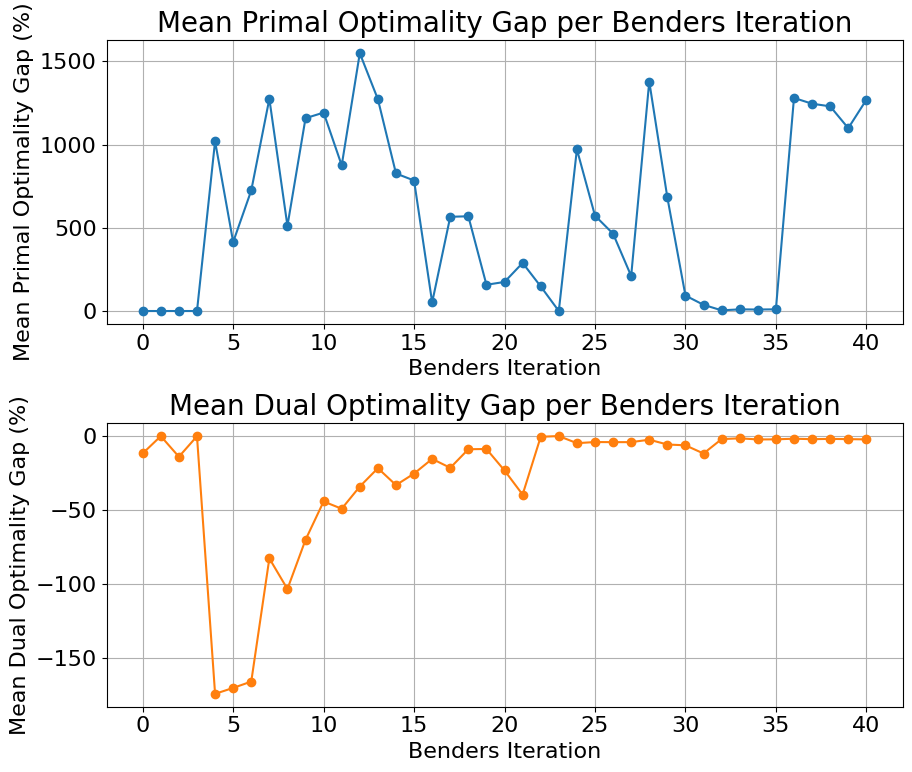

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Primal
group_size = 120
primal_opt_gap_np_benders = primal_opt_gap_benders
num_groups_primal = len(primal_opt_gap_np_benders) // group_size
grouped_means_primal = [
    np.mean(primal_opt_gap_np_benders[i * group_size:(i + 1) * group_size] * 100)
    for i in range(num_groups_primal)
]

# Dual
dual_opt_gap_np_benders = dual_opt_gap_benders.detach().cpu().numpy()
num_groups_dual = len(dual_opt_gap_np_benders) // group_size
grouped_means_dual = [
    np.mean(dual_opt_gap_np_benders[i * group_size:(i + 1) * group_size] * 100)
    for i in range(num_groups_dual)
]

plt.figure(figsize=(10, 8))
plt.rcParams.update({
    "axes.titlesize": 20,
    "axes.labelsize": 16,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16,
    "font.size": 16
})

# Top: Primal
ax1 = plt.subplot(2, 1, 1)
ax1.plot(grouped_means_primal, marker='o', color='tab:blue')
ax1.set_xlabel("Benders Iteration")
ax1.set_ylabel("Mean Primal Optimality Gap (%)")
ax1.set_title("Mean Primal Optimality Gap per Benders Iteration")
ax1.grid(True)

# Bottom: Dual
ax2 = plt.subplot(2, 1, 2)
ax2.plot(grouped_means_dual, marker='o', color='tab:orange')
ax2.set_xlabel("Benders Iteration")
ax2.set_ylabel("Mean Dual Optimality Gap (%)")
ax2.set_title("Mean Dual Optimality Gap per Benders Iteration")
ax2.grid(True)

plt.tight_layout()
plt.subplots_adjust(left=0.18, hspace=0.35)  # Increase left margin and vertical space
plt.savefig("figures/ch8-benders_primal_dual_iteration_gaps_vertical.pdf", dpi=300, bbox_inches='tight')
plt.show()

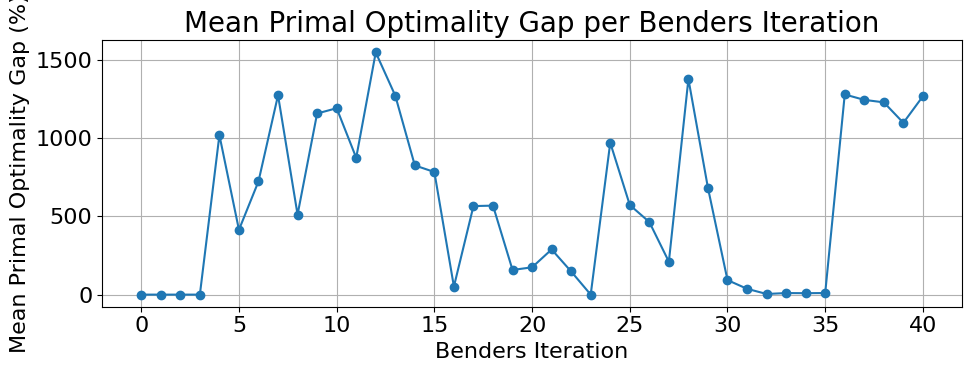

In [59]:
# Divide into groups of 120 and compute the mean for each group
group_size = 120
primal_opt_gap_np_benders = primal_opt_gap_benders
num_groups = len(primal_opt_gap_np_benders) // group_size

grouped_means = [
    np.mean(primal_opt_gap_np_benders[i * group_size:(i + 1) * group_size] * 100)
    for i in range(num_groups)
]

# Plot the means
plt.figure(figsize=(10, 4))
plt.plot(grouped_means, marker='o')
plt.xlabel("Benders Iteration")
plt.ylabel("Mean Primal Optimality Gap (%)")
plt.title("Mean Primal Optimality Gap per Benders Iteration")
plt.grid(True)
plt.tight_layout()
plt.show()

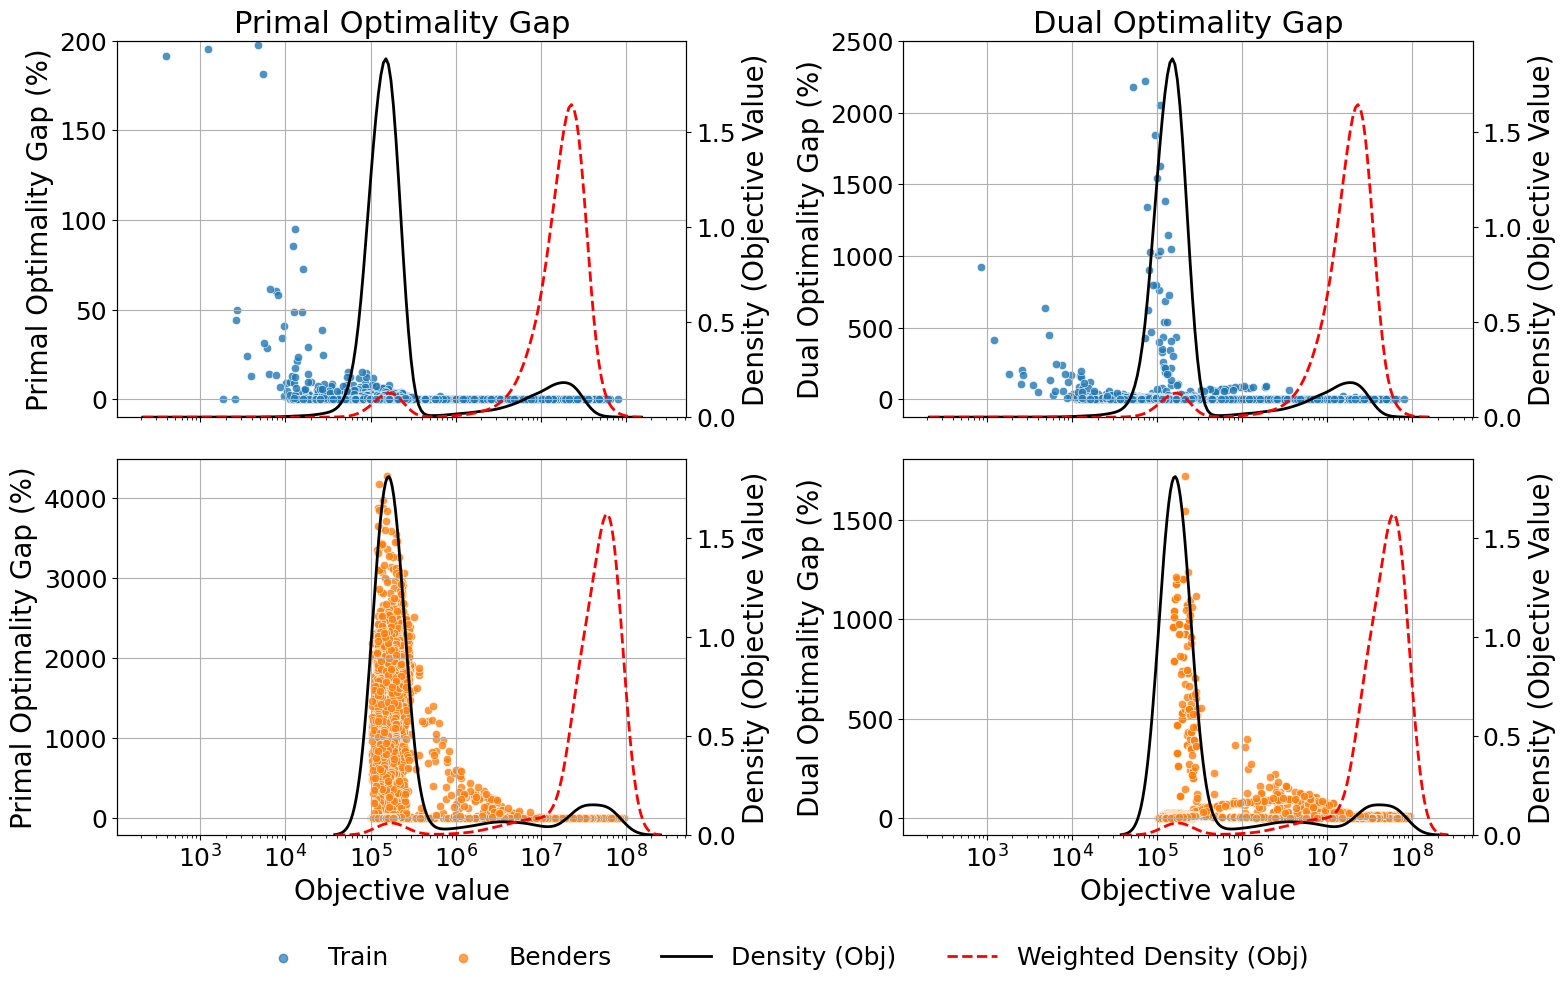

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rcParams.update({
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 17,
    "font.size": 18
})
palette = plt.get_cmap("tab10")
palette = plt.get_cmap("tab10")
point_colors = [palette(0), palette(1)]  # blue, orange

# Data for each subplot: (x, y, title, y_label, point_color, dataset_label)
plot_data = [
    (known_obj_training / pWeight, primal_opt_gap_training * 100, "Primal", "Primal Optimality Gap (%)", point_colors[0], "Train"),
    (known_obj_training / pWeight, -dual_opt_gap_training * 100, "Dual", "Dual Optimality Gap (%)", point_colors[0], "Train"),
    (objs_benders, primal_opt_gap_benders * 100, "Primal", "Primal Optimality Gap (%)", point_colors[1], "Benders"),
    (objs_benders, -dual_opt_gap_benders * 100, "Dual", "Dual Optimality Gap (%)", point_colors[1], "Benders"),
]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10), sharex='col')

# For collecting legend handles/labels
handles = []
labels = []

# Create dummy scatter plots for legend (so they appear first)
dummy_train = plt.scatter([], [], color=point_colors[0], alpha=0.7, label="Train")
dummy_benders = plt.scatter([], [], color=point_colors[1], alpha=0.7, label="Benders")
handles.extend([dummy_train, dummy_benders])
labels.extend(["Train", "Benders"])

# We'll collect density handles/labels from the first subplot
density_handles = []
density_labels = []

for idx, (x, y, metric, y_label, color, dataset) in enumerate(plot_data):
    row = 0 if dataset == "Train" else 1
    col = 0 if metric == "Primal" else 1
    ax = axes[row, col]
    # Scatter plot (no legend)
    sns.scatterplot(
        x=x,
        y=y,
        sizes=(20, 200),
        ax=ax,
        color=color,
        alpha=0.8,
        rasterized=True,
        legend=False
    )
    ax.grid(True)

    if row == 0:
        ax.set_title(f"{metric} Optimality Gap")
    if col == 0:
        ax.set_ylabel(y_label)
    else:
        ax.set_ylabel(y_label)
    if row == 1:
        ax.set_xlabel("Objective value")
    ax.set_xscale('log')

    if row == 0 and col == 0:
        ax.set_ylim(-200*0.05, 200)
    
    if row == 0 and col == 1:
        ax.set_ylim(-2500*0.05, 2500)

    # Secondary y-axis for density
    axb = ax.twinx()
    # Only add density labels/handles for the first subplot
    if row == 0 and col == 0:
        density_line = sns.kdeplot(
            x=x,
            ax=axb,
            color='black',
            linewidth=2,
            label="Density (Obj)",
            legend=False
        )
        weighted_line = sns.kdeplot(
            x=x,
            weights=x,
            ax=axb,
            color='red',
            linewidth=2,
            linestyle='--',
            label="Weighted Density (Obj)",
            legend=False
        )
        h2, l2 = axb.get_legend_handles_labels()
        density_handles.extend(h2)
        density_labels.extend(l2)
    else:
        sns.kdeplot(
            x=x,
            ax=axb,
            color='black',
            linewidth=2,
            legend=False
        )
        sns.kdeplot(
            x=x,
            weights=x,
            ax=axb,
            color='red',
            linewidth=2,
            linestyle='--',
            legend=False
        )
    axb.set_ylabel("Density (Objective Value)")

# Add density lines to the legend after the scatter handles
handles.extend(density_handles)
labels.extend(density_labels)

# Place a single legend below all subplots
fig.legend(handles, labels, loc='lower center', ncol=4, fontsize=18, frameon=False, bbox_to_anchor=(0.5, -0.01))

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig("figures/ch8-optimality-gap-distribution.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [61]:
training_data.pGenAva

{('AUS', 'SunPV', 1): 0.0,
 ('AUS', 'SunPV', 2): 0.0,
 ('AUS', 'SunPV', 3): 0.0,
 ('AUS', 'SunPV', 4): 0.0,
 ('AUS', 'SunPV', 5): 0.0,
 ('AUS', 'SunPV', 6): 0.0,
 ('AUS', 'SunPV', 7): 0.0,
 ('AUS', 'SunPV', 8): 0.01,
 ('AUS', 'SunPV', 9): 0.088,
 ('AUS', 'SunPV', 10): 0.107,
 ('AUS', 'SunPV', 11): 0.097,
 ('AUS', 'SunPV', 12): 0.096,
 ('AUS', 'SunPV', 13): 0.081,
 ('AUS', 'SunPV', 14): 0.076,
 ('AUS', 'SunPV', 15): 0.048,
 ('AUS', 'SunPV', 16): 0.005,
 ('AUS', 'SunPV', 17): 0.0,
 ('AUS', 'SunPV', 18): 0.0,
 ('AUS', 'SunPV', 19): 0.0,
 ('AUS', 'SunPV', 20): 0.0,
 ('AUS', 'SunPV', 21): 0.0,
 ('AUS', 'SunPV', 22): 0.0,
 ('AUS', 'SunPV', 23): 0.0,
 ('AUS', 'SunPV', 24): 0.0,
 ('AUS', 'SunPV', 25): 0.0,
 ('AUS', 'SunPV', 26): 0.0,
 ('AUS', 'SunPV', 27): 0.0,
 ('AUS', 'SunPV', 28): 0.0,
 ('AUS', 'SunPV', 29): 0.0,
 ('AUS', 'SunPV', 30): 0.0,
 ('AUS', 'SunPV', 31): 0.0,
 ('AUS', 'SunPV', 32): 0.017,
 ('AUS', 'SunPV', 33): 0.13,
 ('AUS', 'SunPV', 34): 0.233,
 ('AUS', 'SunPV', 35): 0.289,
 ('AU

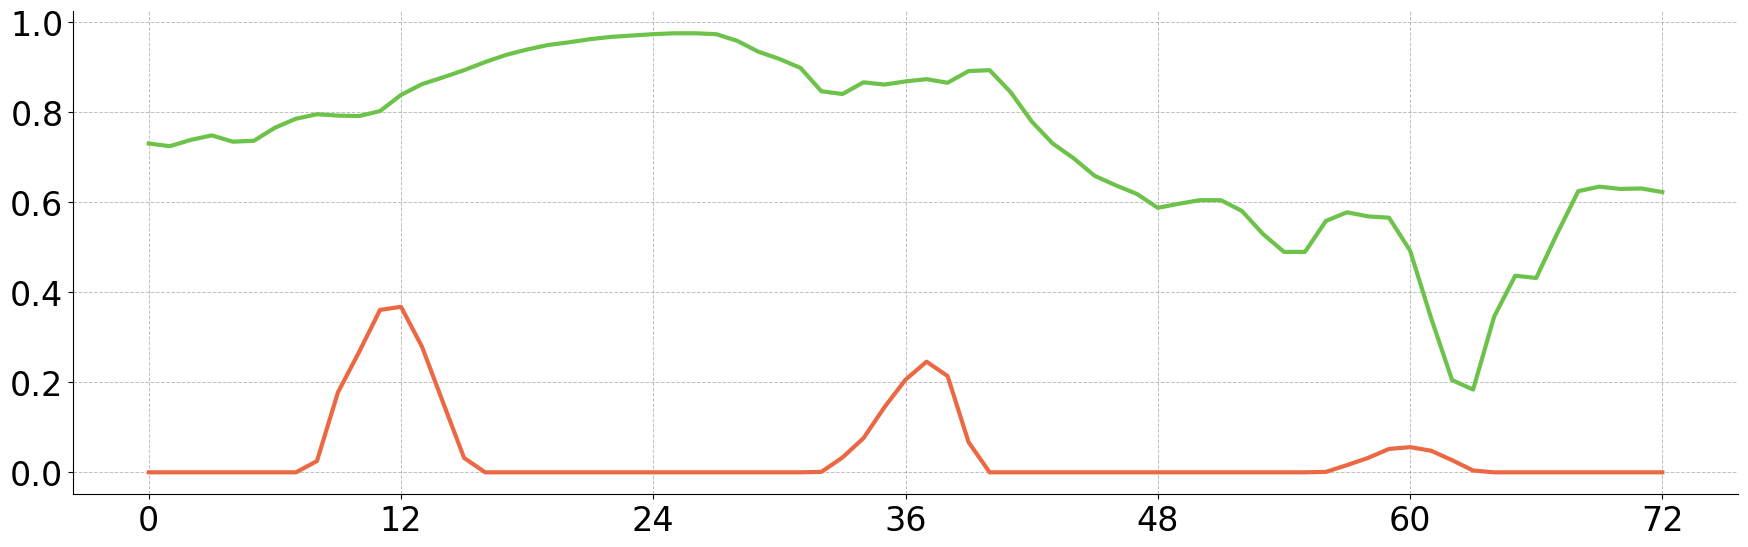

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Set global font sizes for a professional look
plt.rcParams.update({
    "axes.titlesize": 24,
    "axes.labelsize": 24,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "legend.fontsize": 24,
    "font.size": 24
})

profiles = {}
until = 73
techs = ["SunPV", "WindOff"]
for tech in techs:
    profiles[tech] = []
    for i in range(1, until+1):
        profiles[tech].append(training_data.pGenAva[("BEL", tech, i)])

fig, ax = plt.subplots(figsize=(18, 6))

ax.plot(profiles["SunPV"], color='#EC6843', linewidth=3, label="SunPV")
ax.plot(profiles["WindOff"], color='#6DC24A', linewidth=3, label="WindOff")

# Set x-ticks every 12
xticks = np.arange(0, until, 12)
ax.set_xticks(xticks)
ax.set_xticklabels([str(x) for x in xticks])

# Show y-axis and all spines
ax.yaxis.set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(True)

# Add a very faint grid
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7, alpha=0.5, color='gray')

plt.tight_layout()
plt.savefig("bel_sun_wind_profiles.svg", format="svg", bbox_inches='tight', transparent=True)
plt.show()